## Project 3 Report - Collaboration and Competition

- Author: Thiago Akio Nakamura
- Date: July 2021
- Repo: https://github.com/akionakamura/drlnd-p3

### Introduction
This document contains the report for the Project 3 of the Deep Reinforcement Learning Nano Degree from Udacity. The goal of this project is to train an reinforcement learning agent for a multi-agent collaborative problem. This report explains the algorithms used, as well as the tests parameters and the obtained results. The reader is also encouraged to read through the source code, for the detailed implementations of the neural networks and the agent itself.

### The environment
The `Tennis` environment consists in two agents controlling rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play. The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

#### The Goal
The task is episodic, and in order to solve the environment, the agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically:

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single score for each episode.

The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

In [1]:
import os
import time
from collections import deque
from dataclasses import asdict

from unityagents import UnityEnvironment
import mlflow
import numpy as np
import torch

from agents import SingleAgentDDPG
from experiment import RunExperiments, RunConfig

/home/akio/.pyenv/versions/3.6.12/envs/drlnd/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Global constants for the project.
# Number of episodes to train all agents.
NUM_EPISODES = 5000

# Consecutive runs to average the scores.
RESULT_WINDOW = 100

# Minimum average score over the window to complete the project.
MIN_AVERAGE_SCORE = 0.5

In [3]:
experiments_to_run = RunExperiments(
    learn_steps=[2],
    sync_steps=[8],
    batch_sizes=[4096],
    gammas=[0.99],
    epsilon_decays=[0.997]
)
NUM_EXPERIMENTS = 1

In [4]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Learning Algorithms

The environment has both state and actions with continuous values, therefore we cannot use the traditional Q-Learning algorithms for learning. Looking specifically at algorithms designed to work with continuous actions, we are going to train an agent using Deep Deterministic Policy Gradient (DDPG) algorithm [1].

#### DDPG
The Deep Deterministic Policy Gradient (DDPG) that directly learns a policy, i.e., given a state, its output is directly the action to be taken (actor). Concurrently, an DDPG a Q-function to estimate the future return (critic). Therefore, the DDPG method fits within the Actor-Critic family of algorithms. To increase stability, both networks (actor and critic) have mirroring network, usually called target, that is always kept off-sync with the main network weights. In [this link](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) you can find a fine introduction to the algorithm.

#### Multi-agent
In this environment, we have two distinct agents acting in collaboration, to maximize their score. There are several ways of modelling this, but the chose approach was to train a single agent that will taking the actions for both sides of the net. Therefore, all the networks and weights are shared among the left and right player, as well as the replay buffer during training.

In [7]:
def train(num_episodes, env, agent):
    all_scores = []
    score_window = deque(maxlen=RESULT_WINDOW)
    solved = False
    best_mean_score = 0
    
    for episode_i in range(num_episodes):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]      # Reset the environment    
        states = env_info.vector_observations                  # Get the current state (for each agent)
        scores = np.zeros(num_agents)                          # Initialize the score (for each agent)
        done = False

        while not done:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # Send all actions to tne environment
            next_states = env_info.vector_observations         # Get next state (for each agent)
            rewards = env_info.rewards                         # Get reward (for each agent)
            dones = env_info.local_done                        # See if episode finished

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # Send tuples of each agent

            states = next_states                               # Roll over states to next time step
            scores += env_info.rewards                         # Update the score (for each agent)
            
            if np.any(dones):                                  # Exit loop if episode finished
                done = True
        
        agent.episode_finished()
        max_score = np.max(scores)
        score_window.append(max_score)
        all_scores.append(max_score)
        
        current_mean = np.mean(score_window)
        if current_mean >= MIN_AVERAGE_SCORE:
            solved = True
        
        if current_mean > best_mean_score:
            best_mean_score = current_mean
        mlflow.log_metric("current_mean", current_mean, step=episode_i)
        mlflow.log_metric("current_epsilon", agent.epsilon, step=episode_i)
        print(f"\r  Current mean score on episode {episode_i}: {current_mean:.6f}", end="")
        
    return all_scores, solved, best_mean_score, current_mean

#### Training

This class of Reinforcement Learning algorithms can be quite unstable and very sensitive to hyperparameters. Here, we designed an experiment to have several runs with different hyperparameters, and used [MLFlow](https://mlflow.org/) to track the results. The main hyperparameters tweaked were:

1. `learn_step`: how many steps to take into the environment between each learning cycle. Values: `[1, 2, 4]`
2. `sync_step`: how many steps to take into the environment between each synchronization between the weights of the local and target networks (both actor and critic). Values: `[8, 16, 32]`
3. `batch_size`: how many samples to get from the replay buffer at each learning step. Values: `[512, 4096]`
4. `gamma`: the discount factor. Values: `[0.95, 0.99]`
5. `epsilon_decays`: how fast the added noise in the action decreases. Values: `[0.997, 0.999]`

We ran a random search across the hypeparameter space, and the first set of hyperparameters the solved the environment were the following, and the ones used in this report, plus some values that were not part of the hyperparameters search:

1. `learn_step=2`
2. `sync_step=8`
3. `batch_size=4096`
4. `gamma=0.99`
5. `epsilon_decays=0.997`
6. `DEFAULT_TAU=2e-1`
7. `DEFAULT_LR_ACTOR=1e-4` (with `adam` optimizer)
8. `DEFAULT_LR_CRITIC=3e-4` (with `adam` optimizer)

### Network Architecture
#### Actor
The actor network simply gets the state representation as input, and outputs directly the action to be takes (in continuous space), i.e., it represents the policy. The chosen architecture is pretty straight forward, with three fully-connected layers in a row. The hiddens layers have 128 neurons and ReLU activation function, whist the last layer has 4 units (action size) with `tanh` activation layer, leading to number between `[-1, 1]`. Follows the image representing this architecture.
<img src="actor.png">

#### Critic
The Critic network has a role to approximate the Q-function, and therefore receives as input both the state and the action. Its output is a single number representing the projected total return. The state value are first passed through a single fully-connected layer, which result is concatenated to the action tensor. From there on, with follow two more fully-connected layers. All hidden layers have 128 units, except the last, which has 64. Leaky ReLU was used as the activation function, but the output layer has a linear activation, so its value can extend to the real numbers set. Follows the image representing this architecture.
<img src="critic.png">

In [8]:
%%time

experiment_scores = {}
mlflow.set_experiment("tennis-maddpg2")
for i, config in enumerate(experiments_to_run.get_configs(NUM_EXPERIMENTS)):
    with mlflow.start_run(run_name=f"Config {i}"):
        start_time = time.time()
        print(f"Running experiment {i} with config: {config}")
        mlflow.log_params(asdict(config))
        
        agent = SingleAgentDDPG(
            state_size,
            action_size,
            gamma=config.gamma,
            learn_step=config.learn_step,
            sync_step=config.sync_step,
            epsilon_decay=config.epsilon_decay,
            batch_size=config.batch_size
        )

        scores, solved, best_mean_score, last_mean_score = train(NUM_EPISODES, env, agent)
        experiment_scores[config] = scores
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"  Ran experiment in {elapsed} seconds.")
        print(f"  Best mean score of {best_mean_score}.")
        print(f"  Latest mean score of {last_mean_score}.")
        mlflow.log_metric("best_mean_score", best_mean_score)
        mlflow.log_metric("last_mean_score", last_mean_score)

        if solved:
            print("  Solved.")
            os.makedirs(f"./models/{i}/", exist_ok=True)
            agent.save(i)
            break

Running experiment 0 with config: RunConfig(learn_step=2, sync_step=8, batch_size=4096, gamma=0.99, epsilon_decay=0.997)
  Current mean score on episode 4999: 1.128600  Ran experiment in 208806.71156549454 seconds.
  Best mean score of 1.8602000277675688.
  Latest mean score of 1.1286000168696046.
  Solved.
CPU times: user 4d 21h 25min 51s, sys: 12min 24s, total: 4d 21h 38min 16s
Wall time: 2d 10h 6s


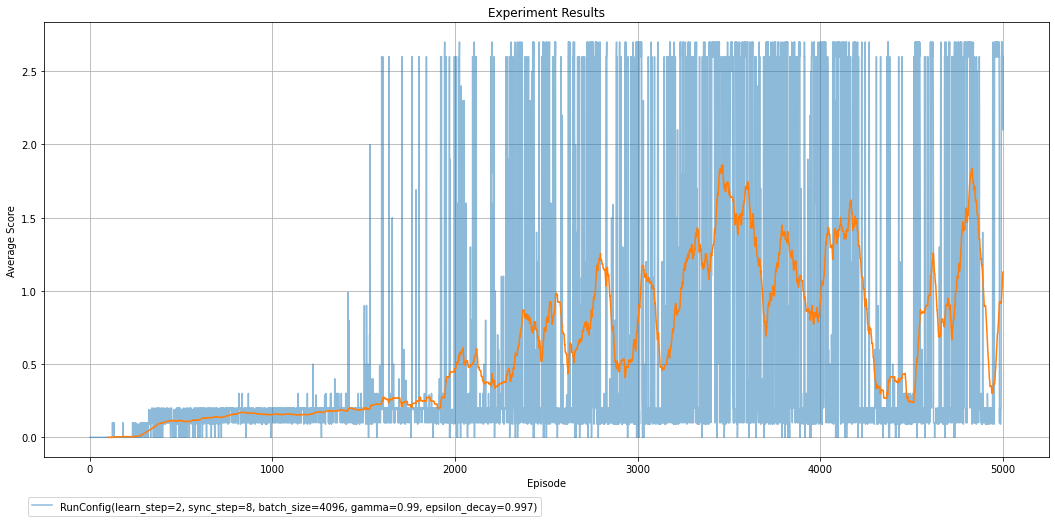

In [15]:
import matplotlib.pyplot as plt

def moving_average(x: np.array, window_size: int):
    """Computes the moving average over the given array."""
    return np.convolve(x, np.ones(window_size), "valid") / window_size


plt.figure(figsize=(18, 8))
for c, scores in experiment_scores.items(): 
    plt.plot(scores, label=c, alpha=0.5)
    moving_average_scores = moving_average(scores, RESULT_WINDOW)
    plt.plot(range(RESULT_WINDOW, NUM_EPISODES+1), moving_average_scores, alpha=1)
    
plt.title("Experiment Results")
plt.ylabel("Average Score")
plt.xlabel("Episode")
plt.legend(bbox_to_anchor=(0.5, -0.08))
plt.grid()
plt.show()

Training over 5000 episodes took a very long time over CPU, especially when the agent get better, since the episode takes longer to terminate. On total, to train this last agent, it took 58 hours. We can also see the training instability, with the agent's performance oscilating throughout the training process. The task was first solved at around episode 2000, where it first reached an average over `0.5`.

Next follows an episode with the trained agent, when we obtain the score for 2.6 for each agent.

In [10]:
agent = SingleAgentDDPG(
    state_size,
    action_size,
    epsilon_start=0.0,
    min_epsilon=0.0)
agent.load(i)

done = False
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
final_score = np.zeros(num_agents)

while not done:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done

    states = next_states
    final_score += env_info.rewards

    if np.any(dones):
        done = True

print(f"Final score: {final_score}")

Final score: [2.60000004 2.60000004]


<img src="trained.gif">

In [11]:
env.close()

### Conclusion

We trained an agent to solve the Tennis environment collaboratively, using the DDPG algorithm. We used a single agent to learning concurrently the policies for both the left and right raquet. After training, the agent got an average return of `+1.1286` in 100 consecutive episodes, but it reached a peak of `1.8602` during training.

### Future Work

For future works we could try to accelerate the training and execution of the algorithm, which was quite slow. For example, the winning agent took 58hrs to train for 5000 epochs (on CPU), the running of several experiments was quite painful. Furthermore, we could try to implement other algorithms, such as MADDPG [2], and the use of Prioritized Experience Replay [3] to make training more efficient.

### References

1. [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)
2. [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/abs/1706.02275)
3. [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)